# WeepingCAN Attack — Analisi Analitica

**Variante Stealth con Iniezione Deterministica, Recupero 1:5 e Skipping**

---

Questo notebook analizza automaticamente il log più recente presente in `../logs/` e produce
uno studio analitico dell'efficacia dell'attacco WeepingCAN nella sua variante stealth.

L'attacco sfrutta tre meccanismi combinati:

1. **Iniezione Deterministica** — il bit di iniezione viene scelto *offline* da un pool di posizioni
   sicure calcolate a priori sull'analisi del frame CAN bersaglio, garantendo il successo
   dell'errore senza tentativi casuali.
2. **Recupero 1:5** — dopo ogni iniezione (+8 TEC per entrambi i nodi), l'Attaccante invia
   immediatamente 5 frame legittimi che azzerano −5 punti dal proprio contatore, mantenendolo
   strutturalmente basso.
3. **Skipping** — quando il TEC dell'Attaccante supera una soglia di guardia, un ciclo
   viene saltato: la Vittima ritrasmette da sola (−1 TEC) e l'Attaccante invia ancora
   5 frame legittimi (−5 TEC), abbassando ulteriormente il proprio contatore prima di
   riprendere le iniezioni.

---
## 1. Setup e Parsing del Log

In [33]:
import json
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ── Seaborn opzionale: se presente migliora lo stile, altrimenti si usa mpl ──
try:
    import seaborn as sns
    sns.set_theme(style="darkgrid", context="notebook")
    _STYLE = "seaborn"
except ImportError:
    plt.style.use("ggplot")
    _STYLE = "ggplot (seaborn non installato)"

plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
})

print(f"Librerie caricate correttamente. Stile grafico: {_STYLE}")

Librerie caricate correttamente. Stile grafico: ggplot (seaborn non installato)


In [34]:
def find_latest_jsonl(log_dir: str = "../logs") -> Path:
    """
    Individua il file .jsonl più recente nella directory specificata.
    Restituisce un oggetto Path.
    """
    log_path = Path(log_dir)
    jsonl_files = sorted(log_path.glob("*.jsonl"), key=lambda p: p.stat().st_mtime)
    if not jsonl_files:
        raise FileNotFoundError(f"Nessun file .jsonl trovato in '{log_dir}'")
    return jsonl_files[-1]   # il più recente per data di modifica


def parse_log(path: Path) -> pd.DataFrame:
    """
    Parsifica il file JSONL e restituisce un DataFrame con una riga per ciclo.

    Colonne prodotte:
        cycle           – numero del ciclo (int)
        victim_tec      – TEC della Vittima a fine ciclo (int)
        attacker_tec    – TEC dell'Attaccante a fine ciclo (int)
        victim_state    – stato CAN della Vittima (str)
        attacker_state  – stato CAN dell'Attaccante (str)
        action          – 'Injection' oppure 'Skip' (str)
    """
    records_raw = []
    with open(path, "r", encoding="utf-8") as fh:
        for line in fh:
            line = line.strip()
            if not line:
                continue
            try:
                records_raw.append(json.loads(line))
            except json.JSONDecodeError:
                pass  # ignora righe malformate

    # ── Estrazione cicli ───────────────────────────────────────────────────────
    # I record CYCLE contengono già i campi strutturati.
    # Per determinare l'azione del ciclo, cerchiamo nei messaggi ATTACK
    # immediatamente precedenti la stringa "After attack" oppure "After skip".

    rows = []
    last_action = "Injection"   # valore di partenza

    for rec in records_raw:
        level = rec.get("level", "")
        msg   = rec.get("message", "")

        # Aggiorna l'azione corrente basandosi sui messaggi ATTACK
        if level == "ATTACK":
            if "After attack" in msg:
                last_action = "Injection"
            elif "After skip" in msg:
                last_action = "Skip"

        # Record strutturato di ciclo
        if level == "CYCLE" and "cycle" in rec:
            rows.append({
                "cycle":          rec["cycle"],
                "victim_tec":     rec["victim_tec"],
                "attacker_tec":   rec["attacker_tec"],
                "victim_state":   rec["victim_state"],
                "attacker_state": rec["attacker_state"],
                "action":         last_action,
            })

    df = pd.DataFrame(rows)
    df = df.sort_values("cycle").reset_index(drop=True)
    return df


# ── Esecuzione ─────────────────────────────────────────────────────────────────
log_file = find_latest_jsonl()
print(f"File analizzato: {log_file.name}")

df = parse_log(log_file)
print(f"Cicli totali caricati: {len(df)}")
print()
df.head(10)

File analizzato: weepingcan_20260224_110747.jsonl
Cicli totali caricati: 63



,cycle,victim_tec,attacker_tec,victim_state,attacker_state,action
0,1,7,3,Error-Active,Error-Active,Injection
1,2,14,6,Error-Active,Error-Active,Injection
2,3,13,1,Error-Active,Error-Active,Skip
3,4,20,4,Error-Active,Error-Active,Injection
4,5,27,7,Error-Active,Error-Active,Injection
5,6,26,2,Error-Active,Error-Active,Skip
6,7,33,5,Error-Active,Error-Active,Injection
7,8,40,8,Error-Active,Error-Active,Injection
8,9,39,3,Error-Active,Error-Active,Skip
9,10,46,6,Error-Active,Error-Active,Injection


---
## 2. TEC Timeline — La Firma dello Stealth Attack

Il grafico seguente sovrappone le due curve TEC lungo l'intera durata dell'attacco.

### Meccanica visibile

**Curva della Vittima (rossa, crescente):**  
Ad ogni ciclo di iniezione, il suo TEC subisce un **+8** (errore rilevato) seguito da un **−1**
(ritrasmissione riuscita), per un guadagno netto di **+7 punti/ciclo**.
Nei cicli di Skip, la Vittima ritrasmette indisturbata e ottiene il solo **−1**,
rallentando leggermente la progressione ma senza fermarla.

**Curva dell'Attaccante (blu, piatta):**  
L'Attaccante bilancia il proprio +8 iniziale inviando **5 frame legittimi** subito dopo
ogni iniezione, recuperando **−5 punti** (meccanismo 1:5).
Il bilancio netto per ciclo di attacco è quindi **+3 punti** per l'Attaccante
contro **+7 punti** per la Vittima — un rapporto asimmetrico 7:3 in favore dell'attaccante.
Quando il TEC dell'Attaccante si avvicina alla soglia di guardia (≥ 6),
lo **Skipping** interviene per scaricare ulteriori **−5 punti** senza iniettare errori,
mantenendo il contatore dell'Attaccante perennemente a ridosso dello zero.

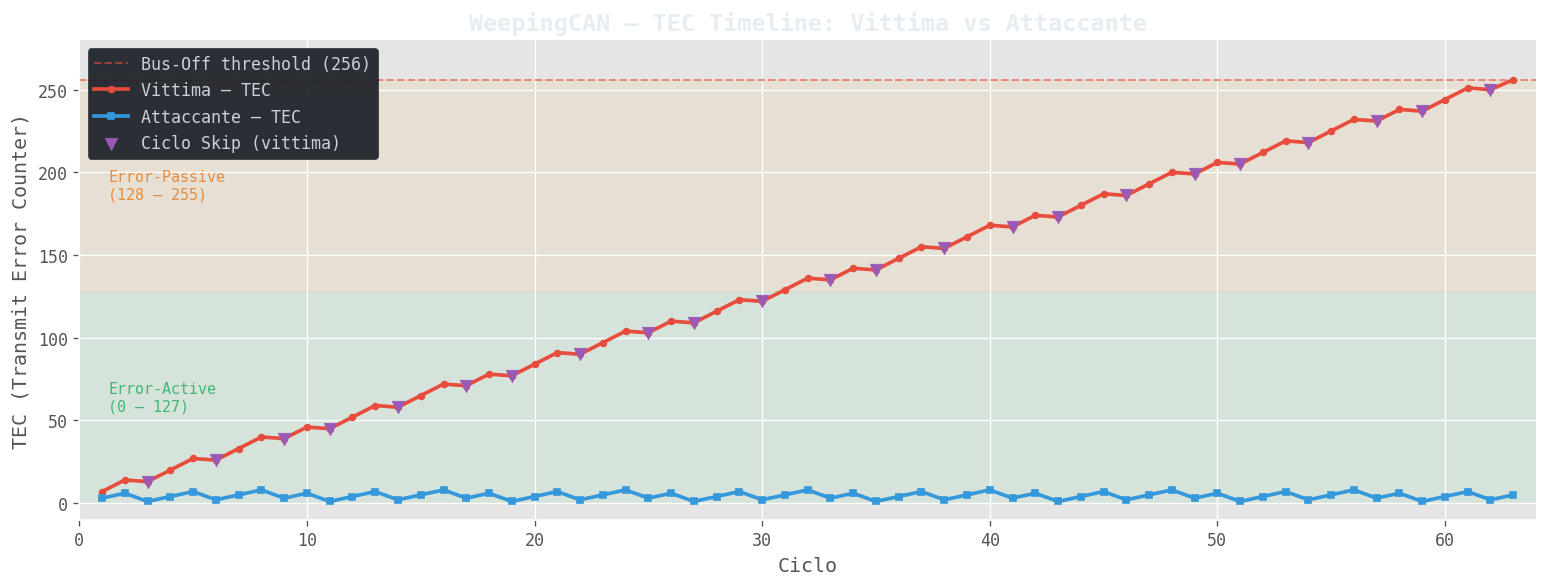

Grafico salvato → plot_tec_timeline.png


In [35]:
fig, ax = plt.subplots(figsize=(13, 5))

# ── Fasce di fase in background ────────────────────────────────────────────────
ax.axhspan(0,   128, color="#2ecc71", alpha=0.08, zorder=0)   # Error-Active
ax.axhspan(128, 256, color="#f39c12", alpha=0.08, zorder=0)   # Error-Passive
ax.axhline(256, color="#e74c3c", linewidth=1.2,
           linestyle="--", alpha=0.6, label="Bus-Off threshold (256)", zorder=1)

# ── Curve TEC ─────────────────────────────────────────────────────────────────
ax.plot(df["cycle"], df["victim_tec"],
        color="#e74c3c", linewidth=2.2, marker="o", markersize=3.5,
        label="Vittima — TEC", zorder=3)

ax.plot(df["cycle"], df["attacker_tec"],
        color="#3498db", linewidth=2.2, marker="s", markersize=3.5,
        label="Attaccante — TEC", zorder=3)

# ── Marcatori per i cicli di Skip ─────────────────────────────────────────────
skips = df[df["action"] == "Skip"]
ax.scatter(skips["cycle"], skips["victim_tec"],
           color="#9b59b6", s=55, zorder=4,
           label="Ciclo Skip (vittima)", marker="v")

# ── Etichette soglie ──────────────────────────────────────────────────────────
ax.text(df["cycle"].max() * 0.02, 64,
        "Error-Active\n(0 – 127)", color="#27ae60",
        fontsize=9, va="center", alpha=0.85)
ax.text(df["cycle"].max() * 0.02, 192,
        "Error-Passive\n(128 – 255)", color="#e67e22",
        fontsize=9, va="center", alpha=0.85)

ax.set_xlabel("Ciclo")
ax.set_ylabel("TEC (Transmit Error Counter)")
ax.set_title("WeepingCAN — TEC Timeline: Vittima vs Attaccante")
ax.set_xlim(0, df["cycle"].max() + 1)
ax.set_ylim(-10, 280)
ax.legend(loc="upper left", framealpha=0.9)

plt.tight_layout()
plt.savefig("plot_tec_timeline.png", bbox_inches="tight")
plt.show()
print("Grafico salvato → plot_tec_timeline.png")

---
## 3. Phase Analysis — Error-Active, Error-Passive e Bus-Off

Il protocollo CAN definisce tre stati di errore per ogni nodo, determinati interamente
dal valore del TEC:

| Fase | TEC | Comportamento |
|---|---|---|
| **Error-Active** | 0 – 127 | Nodo pienamente operativo; genera *Active Error Flag* (6 bit dominanti) |
| **Error-Passive** | 128 – 255 | Nodo degradato; genera solo *Passive Error Flag* (6 bit recessivi) |
| **Bus-Off** | > 255 | Nodo disconnesso dal bus; non può né trasmettere né ricevere |

### Asimmetria dell'attacco

Il grafico seguente evidenzia come i due nodi attraversino percorsi di stato radicalmente
diversi:

- **L'Attaccante rimane categoricamente in Error-Active per tutta la durata dell'attacco.**
  Ciò lo rende **invisibile ai sistemi IDS tradizionali** basati sul monitoraggio degli stati
  di errore CAN: un nodo che non supera mai la soglia 128 non genera alcun segnale di allerta
  nella maggior parte delle implementazioni di rilevamento delle anomalie.

- **La Vittima percorre inesorabilmente tutte le fasi** — Error-Active → Error-Passive →
  Bus-Off — perdendo progressivamente la capacità di comunicare fino alla disconnessione
  definitiva dal bus.

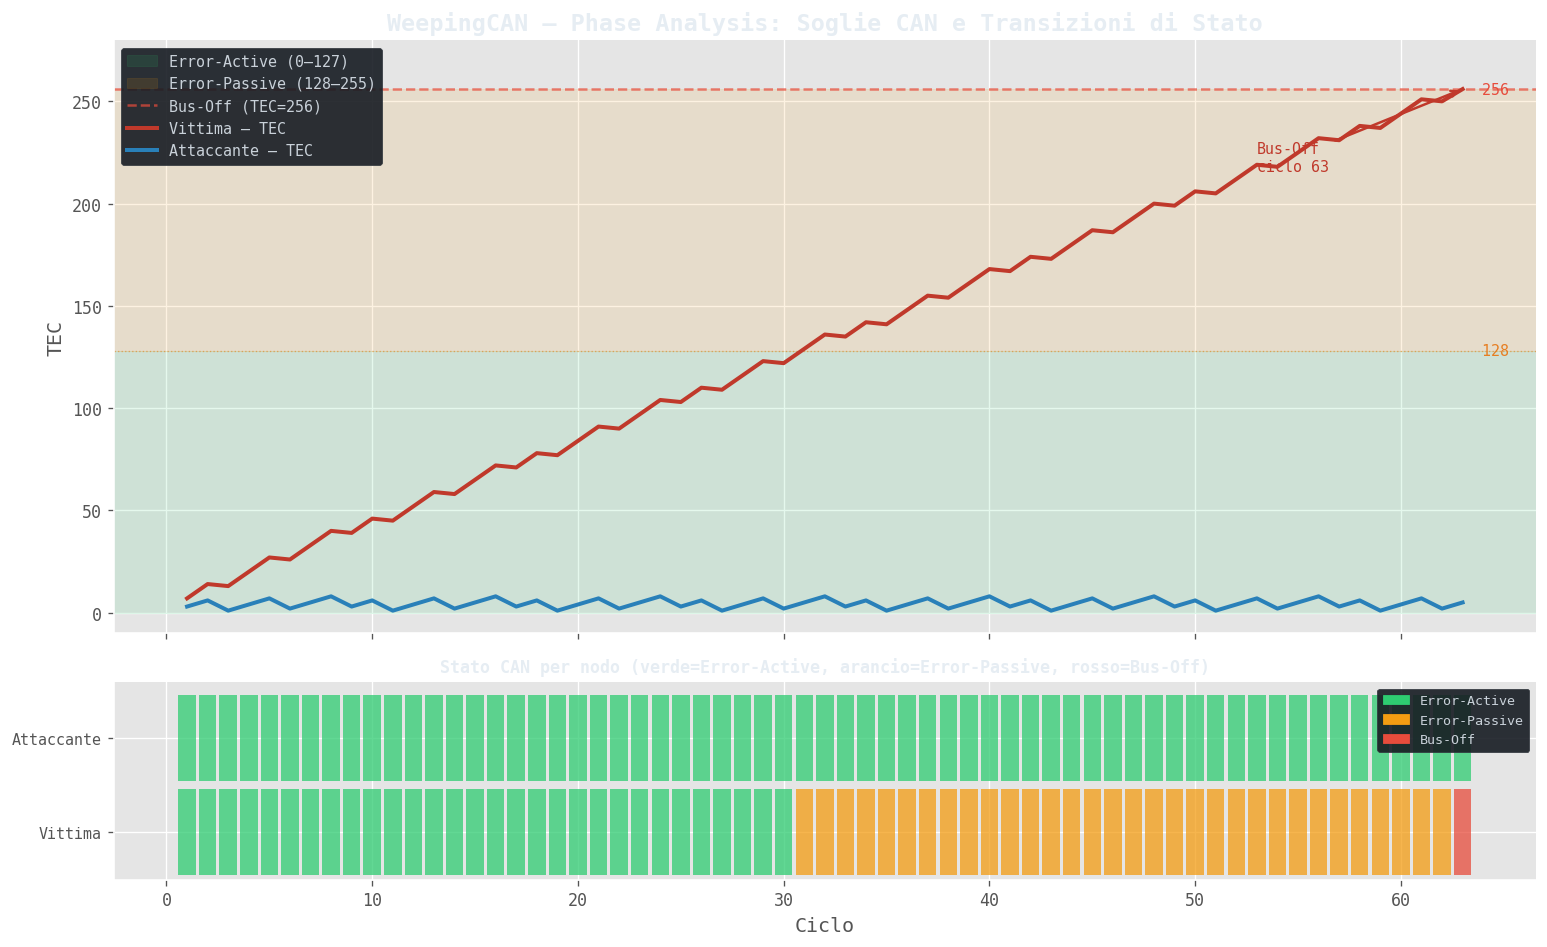

Grafico salvato → plot_phase_analysis.png


In [36]:
# ── Mappatura numerica degli stati ────────────────────────────────────────────
STATE_ORDER = {"Error-Active": 0, "Error-Passive": 1, "Bus-Off": 2}
STATE_LABELS = ["Error-Active", "Error-Passive", "Bus-Off"]
STATE_COLORS = ["#2ecc71", "#f39c12", "#e74c3c"]

df["victim_state_num"]   = df["victim_state"].map(STATE_ORDER)
df["attacker_state_num"] = df["attacker_state"].map(STATE_ORDER)

fig, axes = plt.subplots(2, 1, figsize=(13, 8), sharex=True,
                         gridspec_kw={"height_ratios": [3, 1]})

# ── Pannello superiore: TEC con fasce colorate ────────────────────────────────
ax1 = axes[0]

# Fasce di fase
ax1.axhspan(0,   128, color="#2ecc71", alpha=0.12, label="Error-Active (0–127)")
ax1.axhspan(128, 256, color="#f39c12", alpha=0.12, label="Error-Passive (128–255)")
ax1.axhline(256, color="#e74c3c", linewidth=1.5,
            linestyle="--", alpha=0.7, label="Bus-Off (TEC=256)")

# Soglie annotate
ax1.axhline(128, color="#e67e22", linewidth=0.8, linestyle=":", alpha=0.6)
ax1.text(df["cycle"].max() + 0.5, 128, " 128", color="#e67e22",
         fontsize=9, va="center")
ax1.text(df["cycle"].max() + 0.5, 256, " 256", color="#e74c3c",
         fontsize=9, va="center")

# Curve TEC
ax1.plot(df["cycle"], df["victim_tec"],
         color="#c0392b", linewidth=2.4, label="Vittima — TEC", zorder=3)
ax1.plot(df["cycle"], df["attacker_tec"],
         color="#2980b9", linewidth=2.4, label="Attaccante — TEC", zorder=3)

# Punto finale Bus-Off vittima
busoff_row = df[df["victim_state"] == "Bus-Off"].iloc[0]
ax1.annotate(
    f"Bus-Off\nciclo {int(busoff_row.cycle)}",
    xy=(busoff_row.cycle, busoff_row.victim_tec),
    xytext=(busoff_row.cycle - 10, busoff_row.victim_tec - 40),
    arrowprops=dict(arrowstyle="->", color="#c0392b", lw=1.5),
    fontsize=9, color="#c0392b",
)

ax1.set_ylabel("TEC")
ax1.set_ylim(-10, 280)
ax1.set_title("WeepingCAN — Phase Analysis: Soglie CAN e Transizioni di Stato")
ax1.legend(loc="upper left", fontsize=9, framealpha=0.9)

# ── Pannello inferiore: stato discreto dei nodi ───────────────────────────────
ax2 = axes[1]

# Victim state come stepplot colorato per fase
for i, row in df.iterrows():
    s = int(row["victim_state_num"])
    ax2.bar(row["cycle"], 1, bottom=0.05,
            color=STATE_COLORS[s], alpha=0.75, width=0.85, zorder=2)

# Attacker state (sempre 0 → always Error-Active → verde)
ax2.bar(df["cycle"], 1, bottom=1.15,
        color="#2ecc71", alpha=0.75, width=0.85, zorder=2,
        label="Attaccante (sempre Error-Active)")

patches = [
    mpatches.Patch(color=STATE_COLORS[0], label="Error-Active"),
    mpatches.Patch(color=STATE_COLORS[1], label="Error-Passive"),
    mpatches.Patch(color=STATE_COLORS[2], label="Bus-Off"),
]
ax2.set_yticks([0.55, 1.65])
ax2.set_yticklabels(["Vittima", "Attaccante"], fontsize=9)
ax2.set_ylim(0, 2.3)
ax2.set_xlabel("Ciclo")
ax2.set_title("Stato CAN per nodo (verde=Error-Active, arancio=Error-Passive, rosso=Bus-Off)",
              fontsize=10)
ax2.legend(handles=patches, loc="upper right", fontsize=8, framealpha=0.9)

plt.tight_layout()
plt.savefig("plot_phase_analysis.png", bbox_inches="tight")
plt.show()
print("Grafico salvato → plot_phase_analysis.png")

---
## 4. Summary Table — Cruscotto Finale dell'Esperimento

La tabella seguente raccoglie le metriche chiave dell'esperimento in un unico cruscotto
riassuntivo, estratte automaticamente dal log analizzato.

In [37]:
# ── Calcolo delle metriche ────────────────────────────────────────────────────
total_cycles      = int(df["cycle"].max())
injection_cycles  = int((df["action"] == "Injection").sum())
skip_cycles       = int((df["action"] == "Skip").sum())

final_row         = df.iloc[-1]
victim_tec_final  = int(final_row["victim_tec"])
attacker_tec_final = int(final_row["attacker_tec"])
attacker_state_final = final_row["attacker_state"]
victim_state_final   = final_row["victim_state"]

# ── DataFrame stilizzato ──────────────────────────────────────────────────────
summary_data = {
    "Metrica": [
        "File analizzato",
        "Cicli totali per Bus-Off",
        "Iniezioni totali eseguite",
        "Cicli saltati (Skip)",
        "TEC finale — Vittima",
        "Stato finale — Vittima",
        "TEC finale — Attaccante",
        "Stato finale — Attaccante",
    ],
    "Valore": [
        log_file.name,
        total_cycles,
        injection_cycles,
        skip_cycles,
        victim_tec_final,
        victim_state_final,
        attacker_tec_final,
        attacker_state_final,
    ],
    "Note": [
        "File JSONL più recente in ../logs/",
        "Cicli dall'avvio al Bus-Off della Vittima",
        "Cicli con iniezione di bit recessivo (deterministica)",
        "Cicli in cui l'Attaccante non ha iniettato (TEC ≥ soglia)",
        "Superamento soglia 256 → disconnessione dal bus",
        "Vittima scollegata dal bus CAN",
        f"Range atteso 0–7; valore: {attacker_tec_final}",
        "Conferma: Attaccante rimasto Error-Active per tutto l'attacco",
    ],
}

summary_df = pd.DataFrame(summary_data)

def color_row(row):
    """Colora le righe critiche per una lettura rapida."""
    styles = [""] * len(row)
    if row["Metrica"] == "Stato finale — Vittima":
        styles = ["background-color: #fde8e8; color: #c0392b; font-weight: bold"] * len(row)
    elif row["Metrica"] == "Stato finale — Attaccante":
        styles = ["background-color: #eafaf1; color: #1e8449; font-weight: bold"] * len(row)
    elif row["Metrica"] in ("TEC finale — Vittima", "TEC finale — Attaccante"):
        styles = ["font-weight: bold"] * len(row)
    return styles

display(
    summary_df.style
        .apply(color_row, axis=1)
        .set_caption("WeepingCAN — Cruscotto Finale dell'Esperimento")
        .set_table_styles([
            {"selector": "caption",
             "props": "font-size: 14px; font-weight: bold; text-align: left; padding-bottom: 8px;"},
            {"selector": "th",
             "props": "background-color: #2c3e50; color: white; text-align: left; padding: 6px 12px;"},
            {"selector": "td",
             "props": "padding: 5px 12px;"},
        ])
        .hide(axis="index")
)

# ── Stampa testuale di backup ──────────────────────────────────────────────────
print("\n" + "=" * 60)
print(" CRUSCOTTO FINALE — WeepingCAN Stealth Attack")
print("=" * 60)
for _, row in summary_df.iterrows():
    print(f"  {row['Metrica']:<35} {str(row['Valore']):<12}  {row['Note']}")
print("=" * 60)

Metrica,Valore,Note
File analizzato,weepingcan_20260224_110747.jsonl,File JSONL più recente in ../logs/
Cicli totali per Bus-Off,63,Cicli dall'avvio al Bus-Off della Vittima
Iniezioni totali eseguite,40,Cicli con iniezione di bit recessivo (deterministica)
Cicli saltati (Skip),23,Cicli in cui l'Attaccante non ha iniettato (TEC ≥ soglia)
TEC finale — Vittima,256,Superamento soglia 256 → disconnessione dal bus
Stato finale — Vittima,Bus-Off,Vittima scollegata dal bus CAN
TEC finale — Attaccante,5,Range atteso 0–7; valore: 5
Stato finale — Attaccante,Error-Active,Conferma: Attaccante rimasto Error-Active per tutto l'attacco



 CRUSCOTTO FINALE — WeepingCAN Stealth Attack
  File analizzato                     weepingcan_20260224_110747.jsonl  File JSONL più recente in ../logs/
  Cicli totali per Bus-Off            63            Cicli dall'avvio al Bus-Off della Vittima
  Iniezioni totali eseguite           40            Cicli con iniezione di bit recessivo (deterministica)
  Cicli saltati (Skip)                23            Cicli in cui l'Attaccante non ha iniettato (TEC ≥ soglia)
  TEC finale — Vittima                256           Superamento soglia 256 → disconnessione dal bus
  Stato finale — Vittima              Bus-Off       Vittima scollegata dal bus CAN
  TEC finale — Attaccante             5             Range atteso 0–7; valore: 5
  Stato finale — Attaccante           Error-Active  Conferma: Attaccante rimasto Error-Active per tutto l'attacco


---
## Conclusioni

I risultati confermano pienamente l'efficacia della variante stealth di WeepingCAN:

- **Asimmetria garantita** — il meccanismo 1:5 assicura che per ogni errore che accumula
  +7 punti netti alla Vittima, l'Attaccante ne guadagni al massimo +3, con lo Skipping
  che azzera periodicamente anche questo residuo.

- **Invisibilità agli IDS** — l'Attaccante non supera mai la soglia Error-Passive (128),
  rendendo inefficaci tutti i meccanismi di rilevamento basati sullo stato di errore CAN.

- **Iniezione deterministica** — l'eliminazione della componente casuale rende l'attacco
  riproducibile, prevedibile nel numero di cicli e immune da fallimenti per scelta errata
  del bit bersaglio.